# Assignment 2

## Part 1: Image Processing Basics

Computers use tiny dots called _pixels_ to display images. Each pixel is stored as an array of numbers that represent color intensities.

__Example.__ In an 8-bit grayscale image, each pixel is a single number. The number represents light intensity ranging from black (0) to white (255).

__Example.__ In a 24-bit RGB color image, each pixel is an array of 3 numbers. These numbers range from 0 to 255 and represent red, green, and blue intensity, respectively. For instance, `(0, 0, 255)` is <span style="color:#00F">bright blue</span> and `(255, 128, 0)` is <span style="color:#FF8000">orange</span>.

In this assignment, you'll use Python and NumPy to manipulate 24-bit RGB color images.

You can use `Image.open()` from the Python imaging library (PIL) to open an image:

In [4]:
from PIL import Image

# Cat image from https://unsplash.com/photos/FqkBXo2Nkq0
cat_img = Image.open("cat.png")
timbs_img = Image.open("timbs.png")

Images display inline in Jupyter notebooks:

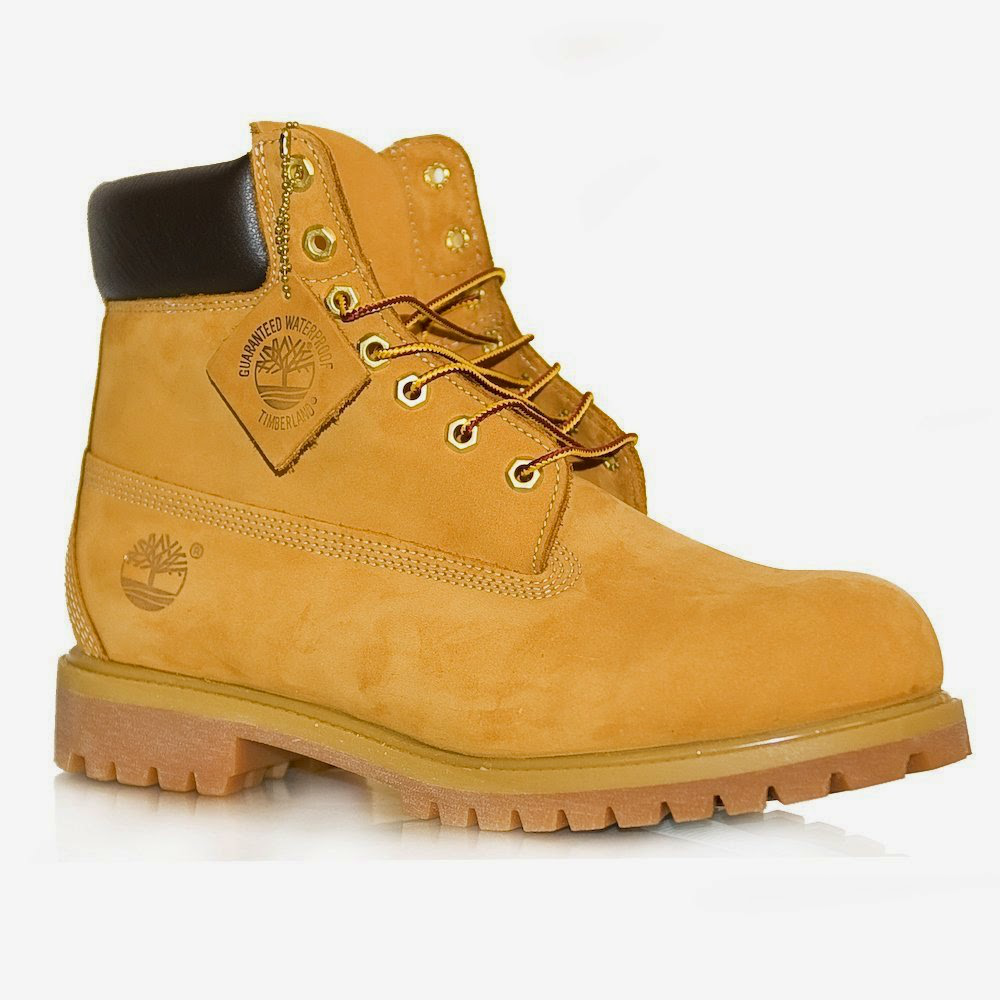

In [5]:
timbs_img

In a Python terminal, you can display the image in a new window with `.show()` instead.

NumPy can convert images to arrays:

In [3]:
import numpy as np

cat = np.array(cat_img)

In [6]:
timbs=np.array(timbs)

To convert an array back to an image (for display) use the function below:

In [7]:
def as_image(x):
    """Convert an ndarray to an Image.
    
    Args:
        x (ndarray): The array of pixels.
        
    Returns:
        Image: The Image object.
    """
    return Image.fromarray(np.uint8(x))

__Exercise 1.1.__ How many dimensions does the `cat` array have? What does each dimension represent?

In [8]:
#Exercise 1.1

timbs.shape

(1000, 1000, 3)

The first two dimensions represent the horizontal and vertical pixels of the image respectively. The last dimension represents the RGB color values at each respective pixel.

__Exercise 1.2.__ Use `.copy()` to copy the cat array to a new variable. Swap the green and blue color channels in the copy. Display the result.

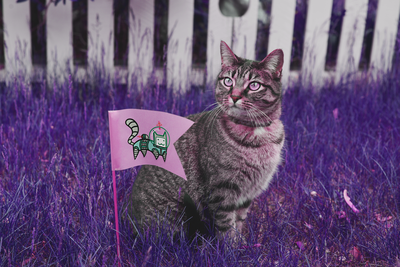

In [45]:
newcat = cat.copy()

newcat[:,:,1:]=newcat[:,:,:0:-1]

as_image(newcat)

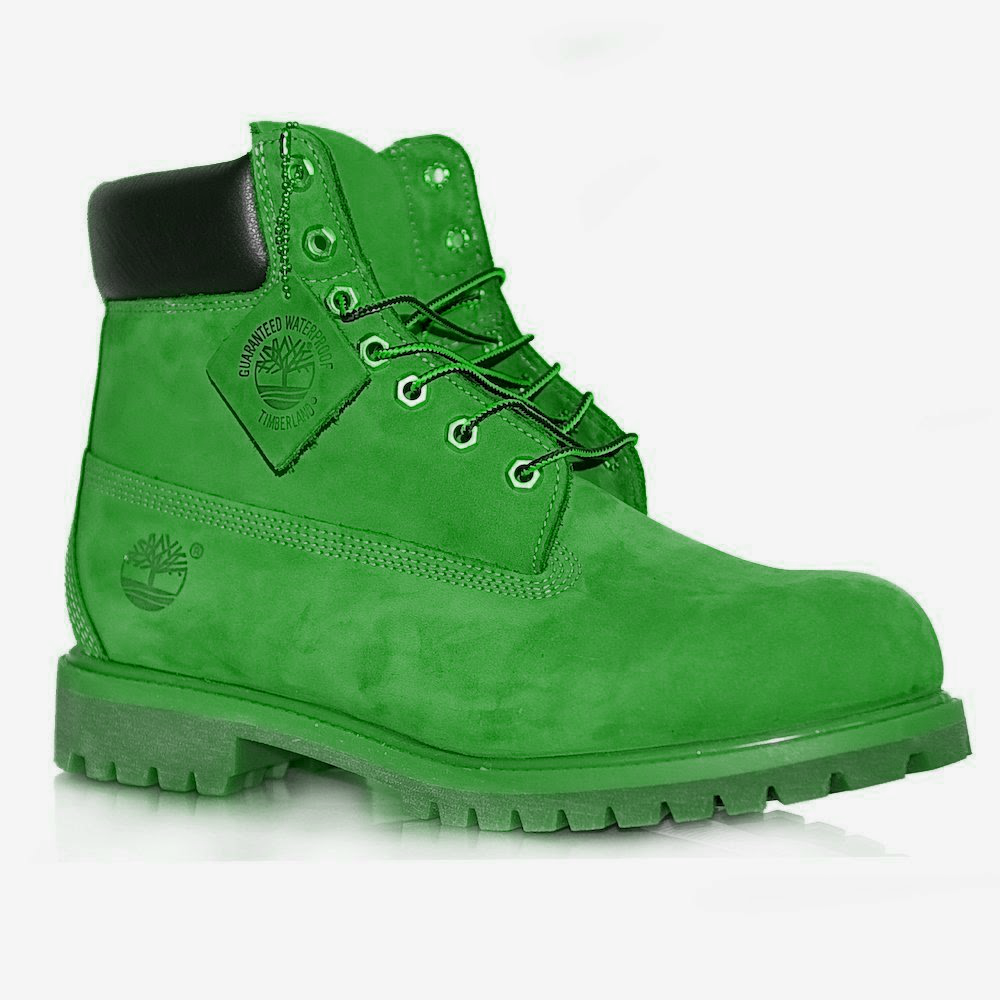

In [11]:
newtimbs=timbs.copy()

newtimbs[:,:,0:2]=newtimbs[:,:,:0:-1]

as_image(newtimbs)

__Exercise 1.3.__ Why is `.copy()` necessary in exercise 1.2? What happens if you don't use `.copy()`?

We need the .copy(), the original array will be overwritten and then we will lose access to the original values.

__Exercise 1.4.__ Flip the blue color channel from left to right. Display the resulting image. _Hint: see the NumPy documentation on array manipulation routines._

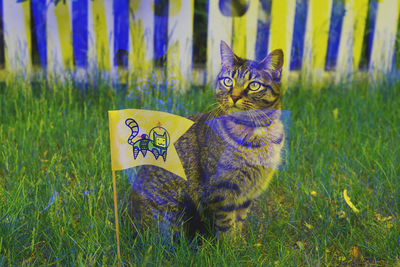

In [533]:
bluecat=cat.copy()
bluecat[:,:,2]=np.fliplr(bluecat[:,:,2])
as_image(bluecat)

## Part 2: Singular Value Decomposition

Suppose $X$ is an $n \times p$ matrix (for instance, one color channel of the cat image). The _singular value decomposition_ (SVD) factors $X$ as $X = UD V^T$, where:

* $U$ is an $n \times n$ orthogonal matrix
* $D$ is an $n \times p$ matrix with zeroes everywhere except the diagonal
* $V$ is an $p \times p$ orthogonal matrix

Note that a matrix $A$ is _orthogonal_ when $A^T A = I$ and $AA^T = I$.

__Example.__ We can use NumPy to compute the SVD for a matrix:

In [319]:
x = np.array(
    [[0, 2, 3],
     [3, 2, 1]]
)
u, d, vt = np.linalg.svd(x)

x
# Here d is 2x2 because NumPy only returns the diagonal of D.
print("u is:\n", u, "\nd is:\n", d, "\nv^T is:\n", vt)

u is:
 [[-0.68145174 -0.73186305]
 [-0.73186305  0.68145174]] 
d is:
 [ 4.52966162  2.54600974] 
v^T is:
 [[-0.48471372 -0.62402665 -0.6128975 ]
 [ 0.80296442 -0.03960025 -0.59470998]
 [ 0.34684399 -0.78039897  0.52026598]]


If we let

* $u_i$ denote the $i$th column of $U$
* $d_i$ denote the $i$th diagonal element of $D$
* $v_i$ denote the $i$th column of $V$

then we can write the SVD as $\ X = UDV^T = d_1 u_1 v_1^T + \ldots + d_m u_m v_m^T\ $ using the rules of matrix multiplication. In other words, the SVD decomposes $X$ into a sum!

If we eliminate some of the terms in the sum, we get a simple approximation for $X$. For instance, we could eliminate all but first 3 terms to get the approximation $X \approx d_1 u_1 v_1^T + d_2 u_2 v_2^T + d_3 u_3 v_3^T$. This is the same as if we:

* Zero all but the first 3 diagonal elements of $D$ to get $D_3$, then compute $X \approx UD_3V^T$
* Eliminate all but the first 3 columns of $V$ to get $p \times 3$ matrix $V_3$, then compute $X \approx UDV_3^T$

We always eliminate terms starting from the end rather than the beginning, because these terms contribute the least to $X$.

Why would we want to approximate a matrix $X$?

In statistics, _principal components analysis_ uses this approximation to reduce the dimension (number of covariates) in a  centered (mean 0) data set. The vectors $d_i u_i$ are called the _principal components_ of $X$. The vectors $v_i^T$ are called the _basis vectors_. Note that both depend on $X$. The dimension is reduced by using the first $q$ principal components instead of the original $p$ covariates. In other words, the $n \times p$ data $X$ is replaced by the $n \times q$ data $UD_q = XV_q$

In computing, this approximation is sometimes used to reduce the number of bits needed to store a matrix (or image). If $q$ terms are kept, then only $nq + pq$ values (for $XV_q$ and $V_q^T$) need to be stored instead of the uncompressed $np$ values.

__Exercise 2.1.__ Write the functions described below.

* A function that takes a matrix $X$ and returns its principal component matrix $XV_q$ and basis matrix $V_q^T$. This function should also take the number of terms kept $q$ as an argument.

* A function that takes a principal component matrix $XV_q$ and basis matrix $V_q^T$ and returns an approximation $\hat{X}$ for the original matrix.

As usual, make sure to document your functions. Test your function on the red color channel of the cat image. What's the smallest number of terms where the cat is still recognizable as a cat?

In [13]:
def getComponents(X,q):
    """Get the q principal components and basis(q) of a data matrix
    Args:
        X (ndarray): The data matrix.
        q (int): The number of terms in the SVD to keep.
    Returns:
        XVQ: The principal component matrix (n x q).
        VQT: The basis approximation (q x p)"""
    u,d,vt=np.linalg.svd(X)
    VQT=vt[:q,:]
    XVQ=np.dot(X,VQT.T)
    return(XVQ,VQT)

def getApprox(XVQ,VQT):
    """Get the approximation of the data matrix X with the product of the principal components and the basis matrix.
    Args:
        XVQ (ndarray): The principal component matrix.
        VQT (ndarray): The basis matrix of order q.
    Returns:
        approx (ndarray): The approximation of the data matrix X."""
    approx=np.dot(XVQ,VQT)
    return(approx)

In [14]:
def getFuzzyCat(q):
    """Compress the red channel of the cat image into a compressed image with q SVD terms
    Args:
        q (int): The number of terms in the SVD to keep.
    Returns:
        fuzzycat (ndarray): The red channel image with the values being estimated by SVD"""
    fuzzycat=timbs.copy()
    fuzzycatRed=fuzzycat[:,:,0]
    print("Getting principal components...")
    fuzzycomponents=getComponents(fuzzycatRed,q)
    print("Done!")
    fuzzyapprox=getApprox(fuzzycomponents[0],fuzzycomponents[1])
    return(fuzzyapprox)

fuzzycat8=getFuzzyCat(8)

Getting principal components...
Done!


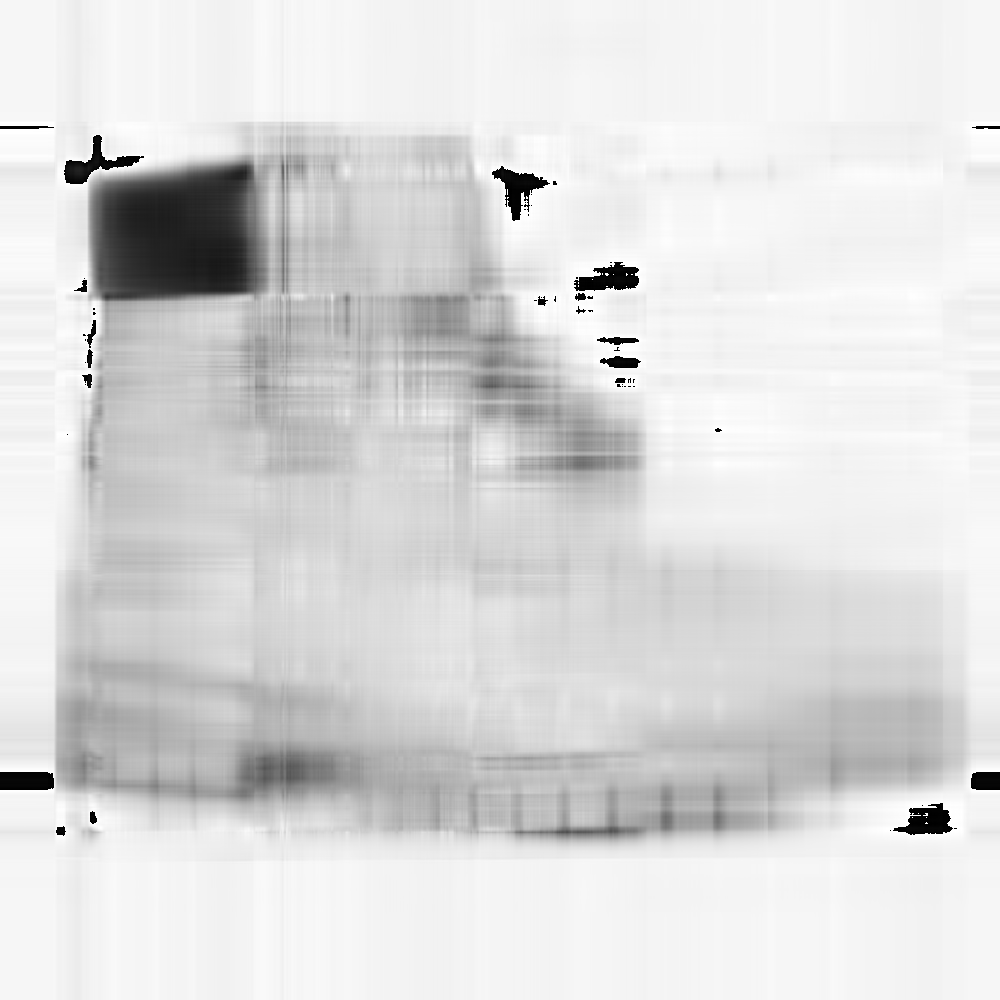

In [15]:
as_image(fuzzycat8)

__Conclusion:__ The image is recognizable up to about 8 principal components.

__Exercise 2.2.__ You can check the number of bytes used by a NumPy array with the `.nbytes` attribute. How many bytes does the red color channel of the cat image use? How many bytes does the compressed version use when 10 terms are kept? What percentage of the original size is this?

In [16]:
fuzzycomp10=getComponents(cat[:,:,0],10)
print("Number of bytes in red channel for original image:",cat[:,:,0].nbytes)
print("Number of bytes in sum of compressed matrices for 10-term image:", fuzzycomp10[0].nbytes+fuzzycomp10[1].nbytes)
print("Percent change in bytes:",(fuzzycomp10[0].nbytes+fuzzycomp10[1].nbytes)/cat[:,:,0].nbytes)

Number of bytes in red channel for original image: 106800
Number of bytes in sum of compressed matrices for 10-term image: 53360
Percent change in bytes: 0.49962546816479403


__Conclusion:__ With 10 terms kept, the data has been compressed by about 50%.